# CNN solubility
Notebook version of the CNN solubility workflow (adapted from the provided Colab script).

Uses the cleaned, scaffold-split CSVs produced in `00_chem_prep.ipynb`; this notebook focuses on modeling only.


## Imports


In [1]:

import json, random, re
import numpy as np
import pandas as pd
from rdkit import Chem

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt


## Tokenizer utilities


In [2]:

# Handles Cl/Br, bracket atoms, and %nn tokens
TOKENIZER_RE = re.compile(r"(\%\d{2}|\[[^\]]+\]|Br|Cl|.)")

def tokenize_smiles(smi: str):
    return TOKENIZER_RE.findall(smi)

def build_vocab(smiles_list, min_freq=1):
    from collections import Counter
    cnt = Counter()
    for s in smiles_list:
        cnt.update(tokenize_smiles(s))
    itos = ["<PAD>", "<UNK>"]
    for tok, f in cnt.most_common():
        if f >= min_freq and tok not in itos:
            itos.append(tok)
    stoi = {t: i for i, t in enumerate(itos)}
    return stoi, itos

def encode_smiles(smi, stoi, max_len):
    ids = [stoi.get(t, stoi["<UNK>"]) for t in tokenize_smiles(smi)[:max_len]]
    if len(ids) < max_len:
        ids += [stoi["<PAD>"]] * (max_len - len(ids))
    return np.array(ids, dtype=np.int64)


## Config and reproducibility


In [3]:

TRAIN_PATH = "../data/train.csv"  # prepared in 00_chem_prep
VAL_PATH = "../data/val.csv"
TEST_PATH = "../data/test.csv"
SMILES_COL = "SMILES"
TARGET_COL = "Solubility"
VOCAB_PATH = "../artifacts/vocab.json"
MODEL_PATH = "../artifacts/best_cnn_attention_norm.pt"

MAX_LEN = 256
EPOCHS = 50
BATCH_SIZE = 128
LR = 2e-3
DROPOUT = 0.25
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


## Load prepared splits


In [4]:

train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)
for name, df in [("train", train_df), ("val", val_df), ("test", test_df)]:
    assert SMILES_COL in df.columns and TARGET_COL in df.columns, f"{name} missing required columns: {list(df.columns)}"

X_train = train_df[SMILES_COL].astype(str).values
X_val = val_df[SMILES_COL].astype(str).values
X_test = test_df[SMILES_COL].astype(str).values
y_train = train_df[TARGET_COL].astype(np.float32).values
y_val = val_df[TARGET_COL].astype(np.float32).values
y_test = test_df[TARGET_COL].astype(np.float32).values

y_mean, y_std = y_train.mean(), y_train.std()
if y_std == 0:
    y_std = 1.0
y_train_norm = (y_train - y_mean) / y_std
y_val_norm = (y_val - y_mean) / y_std
y_test_norm = (y_test - y_mean) / y_std
print("Loaded train/val/test splits from chem prep notebook.")


Loaded train/val/test splits from chem prep notebook.


## Vocabulary, datasets, and dataloaders


In [5]:

stoi, itos = build_vocab(X_train.tolist())
with open(VOCAB_PATH, "w") as f:
    json.dump(itos, f)
print("Vocab size:", len(itos))

class SmilesDataset(Dataset):
    def __init__(self, smiles, y, stoi, max_len):
        self.X = [encode_smiles(s, stoi, max_len) for s in smiles]
        self.y = None if y is None else np.array(y, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        ids = torch.from_numpy(self.X[i])
        if self.y is None:
            return ids
        return ids, torch.tensor(self.y[i])

train_ds = SmilesDataset(X_train, y_train_norm, stoi, MAX_LEN)
val_ds = SmilesDataset(X_val, y_val_norm, stoi, MAX_LEN)
test_ds = SmilesDataset(X_test, y_test_norm, stoi, MAX_LEN)

train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_ld = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)
test_ld = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)


Vocab size: 186


## Model


In [6]:

class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=3, dilation=1, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=dilation * (kernel_size - 1) // 2, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=dilation * (kernel_size - 1) // 2, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.dropout(out)
        return torch.relu(out + residual)

class SmilesCNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, max_len=256, dropout=0.25, num_blocks=3, channels=128, attn_heads=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.input_proj = nn.Conv1d(emb_dim, channels, kernel_size=1)
        self.res_blocks = nn.ModuleList([
            ResidualBlock(channels, kernel_size=3, dilation=2 ** i, dropout=dropout)
            for i in range(num_blocks)
        ])
        self.attn = nn.MultiheadAttention(embed_dim=channels, num_heads=attn_heads, batch_first=True)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.global_max = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(2 * channels, channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(channels, 1)
        )

    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)
        x = self.input_proj(x).transpose(1, 2)
        for block in self.res_blocks:
            x = block(x.transpose(1, 2)).transpose(1, 2)
        attn_out, _ = self.attn(x, x, x)
        x = x + attn_out
        x = x.transpose(1, 2)
        avg = self.global_pool(x).squeeze(-1)
        mx = self.global_max(x).squeeze(-1)
        out = torch.cat([avg, mx], dim=-1)
        return self.fc(out).squeeze(-1)

model = SmilesCNN(vocab_size=len(itos), emb_dim=128, max_len=MAX_LEN, dropout=DROPOUT).to(device)


## Training helpers


In [7]:

opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
crit = nn.MSELoss()

if device == "cuda":
    from torch.amp import GradScaler
    scaler = GradScaler()
else:
    scaler = None

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3)

@torch.no_grad()
def evaluate(model, loader, device, mean=y_mean, std=y_std):
    model.eval()
    preds, targets = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        preds.append(pred.cpu().numpy())
        targets.append(yb.cpu().numpy())
    preds, targets = np.concatenate(preds), np.concatenate(targets)
    preds = preds * std + mean
    targets = targets * std + mean
    rmse = np.sqrt(np.mean((preds - targets) ** 2))
    mae = np.mean(np.abs(preds - targets))
    r2 = 1 - np.sum((preds - targets) ** 2) / np.sum((targets - targets.mean()) ** 2)
    return rmse, mae, r2


## Train loop


In [8]:

best_rmse, best_state, patience, waited = float("inf"), None, 8, 0

for ep in range(1, EPOCHS + 1):
    model.train()
    losses = []
    for xb, yb in tqdm(train_ld, desc=f"Epoch {ep}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        if scaler is not None:
            with torch.amp.autocast():
                pred = model(xb)
                loss = crit(pred, yb)
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            scaler.step(opt)
            scaler.update()
        else:
            pred = model(xb)
            loss = crit(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            opt.step()
        losses.append(loss.item())

    rmse, mae, r2 = evaluate(model, val_ld, device)
    print(f"Epoch {ep:03d} | train_loss {np.mean(losses):.4f} | val_RMSE {rmse:.4f} MAE {mae:.4f} R2 {r2:.3f}")
    scheduler.step(rmse)

    if rmse < best_rmse - 1e-4:
        best_rmse, best_state, waited = rmse, {k: v.cpu() for k, v in model.state_dict().items()}, 0
    else:
        waited += 1
        if waited >= patience:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    torch.save(best_state, MODEL_PATH)
    print(f"Saved best weights to {MODEL_PATH}")


Epoch 001 | train_loss 5.8410 | val_RMSE 2.1808 MAE 1.7704 R2 0.272


Epoch 002 | train_loss 0.5292 | val_RMSE 1.9056 MAE 1.5556 R2 0.444


Epoch 003 | train_loss 0.4166 | val_RMSE 1.8136 MAE 1.4532 R2 0.496


Epoch 004 | train_loss 0.3893 | val_RMSE 2.0210 MAE 1.6140 R2 0.375


Epoch 005 | train_loss 0.3659 | val_RMSE 1.6768 MAE 1.3114 R2 0.570


Epoch 006 | train_loss 0.3495 | val_RMSE 2.2390 MAE 1.8135 R2 0.232


Epoch 007 | train_loss 0.3184 | val_RMSE 1.7250 MAE 1.3729 R2 0.544


Epoch 008 | train_loss 0.3119 | val_RMSE 1.6075 MAE 1.2840 R2 0.604


Epoch 009 | train_loss 0.3109 | val_RMSE 1.9067 MAE 1.5454 R2 0.443


Epoch 010 | train_loss 0.2970 | val_RMSE 1.6863 MAE 1.3524 R2 0.565


Epoch 011 | train_loss 0.2890 | val_RMSE 1.9689 MAE 1.5862 R2 0.406


Epoch 012 | train_loss 0.2802 | val_RMSE 1.6214 MAE 1.2796 R2 0.597


Epoch 013 | train_loss 0.2534 | val_RMSE 1.7795 MAE 1.4497 R2 0.515


Epoch 014 | train_loss 0.2518 | val_RMSE 1.7340 MAE 1.4021 R2 0.540


Epoch 015 | train_loss 0.2458 | val_RMSE 1.6090 MAE 1.2837 R2 0.604


Epoch 016 | train_loss 0.2411 | val_RMSE 1.6014 MAE 1.2558 R2 0.607


Epoch 017 | train_loss 0.2318 | val_RMSE 1.5803 MAE 1.1986 R2 0.618


Epoch 018 | train_loss 0.2355 | val_RMSE 1.6612 MAE 1.3407 R2 0.577


Epoch 019 | train_loss 0.2315 | val_RMSE 1.6197 MAE 1.2750 R2 0.598


Epoch 020 | train_loss 0.2287 | val_RMSE 1.5597 MAE 1.1664 R2 0.628


Epoch 021 | train_loss 0.2228 | val_RMSE 1.5700 MAE 1.2186 R2 0.623


Epoch 022 | train_loss 0.2042 | val_RMSE 1.5135 MAE 1.1750 R2 0.649


Epoch 023 | train_loss 0.2138 | val_RMSE 1.6389 MAE 1.3323 R2 0.589


Epoch 024 | train_loss 0.2130 | val_RMSE 1.5261 MAE 1.1937 R2 0.643


Epoch 025 | train_loss 0.2194 | val_RMSE 1.6791 MAE 1.3326 R2 0.568


Epoch 026 | train_loss 0.2064 | val_RMSE 1.6186 MAE 1.3031 R2 0.599


Epoch 027 | train_loss 0.1929 | val_RMSE 1.6170 MAE 1.2993 R2 0.600


Epoch 028 | train_loss 0.1866 | val_RMSE 1.6467 MAE 1.3312 R2 0.585


Epoch 029 | train_loss 0.1833 | val_RMSE 1.5389 MAE 1.2180 R2 0.637


Epoch 030 | train_loss 0.1782 | val_RMSE 1.5435 MAE 1.2098 R2 0.635
Early stopping.
Saved best weights to ../artifacts/best_cnn_attention_norm.pt


## Final metrics


In [9]:
tr_rmse, tr_mae, tr_r2 = evaluate(model, train_ld, device)
va_rmse, va_mae, va_r2 = evaluate(model, val_ld, device)
te_rmse, te_mae, te_r2 = evaluate(model, test_ld, device)

print("Final metrics")
print(f"Train: RMSE {tr_rmse:.4f} | MAE {tr_mae:.4f} | R2 {tr_r2:.3f}")
print(f"Val:   RMSE {va_rmse:.4f} | MAE {va_mae:.4f} | R2 {va_r2:.3f}")
print(f"Test:  RMSE {te_rmse:.4f} | MAE {te_mae:.4f} | R2 {te_r2:.3f}")

Final metrics
Train: RMSE 1.0602 | MAE 0.7988 | R2 0.829
Val:   RMSE 1.5435 | MAE 1.2098 | R2 0.635
Test:  RMSE 1.4544 | MAE 1.1421 | R2 0.693


## Inference helpers


In [11]:

def preprocess_smiles(smiles_list, stoi, max_len=256):
    processed = []
    for s in smiles_list:
        m = Chem.MolFromSmiles(s)
        if not m:
            continue
        smi = Chem.MolToSmiles(m)
        idxs = [stoi.get(tok, stoi["<UNK>"]) for tok in tokenize_smiles(smi)]
        if len(idxs) < max_len:
            idxs += [stoi["<PAD>"]] * (max_len - len(idxs))
        else:
            idxs = idxs[:max_len]
        processed.append(idxs)
    return torch.tensor(processed, dtype=torch.long)


## Example predictions


Predicted solubilities:


,Compound,SMILES,Predicted Solubility
0,Hexane,CCCCCC,-3.368490
1,Methanol,CO,0.162180
2,Phenol,c1cc(ccc1)O,-0.954797
3,Decanol,CCCCCCCCCCO,-3.315450
4,Hydroquinone,c1cc(ccc1O)O,-0.768174


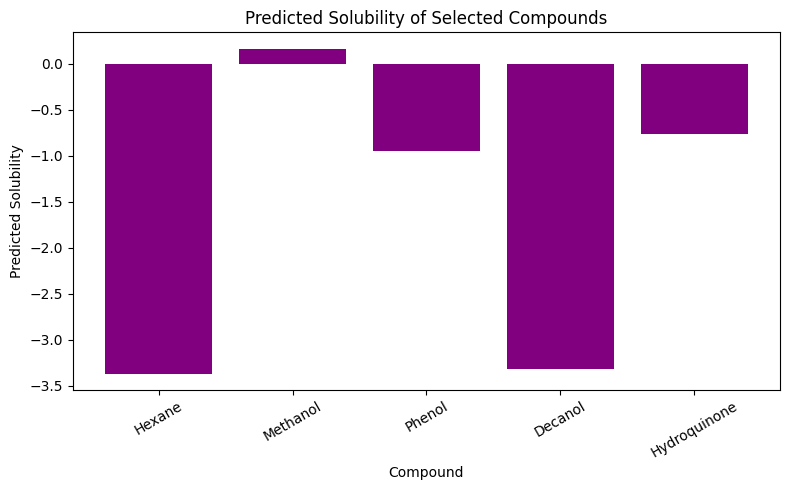

In [12]:

compounds = [
    ("Hexane", "CCCCCC"),
    ("Methanol", "CO"),
    ("Phenol", "c1cc(ccc1)O"),
    ("Decanol", "CCCCCCCCCCO"),
    ("Hydroquinone", "c1cc(ccc1O)O")
]

names, test_smiles = zip(*compounds)
X_test_smiles = preprocess_smiles(test_smiles, stoi, MAX_LEN).to(device)

model.eval()
with torch.no_grad():
    preds_norm = model(X_test_smiles)
    preds = preds_norm * y_std + y_mean

df_results = pd.DataFrame({
    "Compound": names,
    "SMILES": test_smiles,
    "Predicted Solubility": preds.cpu().numpy()
})
print("Predicted solubilities:")
display(df_results)

plt.figure(figsize=(8, 5))
plt.bar(df_results['Compound'], df_results['Predicted Solubility'], color='purple')
plt.xlabel("Compound")
plt.ylabel("Predicted Solubility")
plt.title("Predicted Solubility of Selected Compounds")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## Stress-test predictions


Predicted solubilities (stress-test compounds):


,Compound,SMILES,Predicted Solubility
0,Ethyl acetate,CCOC(=O)C,-0.479286
1,Butanol,CCCCO,-0.758001
2,Acetophenone,CC(=O)c1ccccc1,-2.096653
3,Glycerol,C(C(CO)O)O,0.252714
4,Isobutanol,CC(C)CO,-0.221219


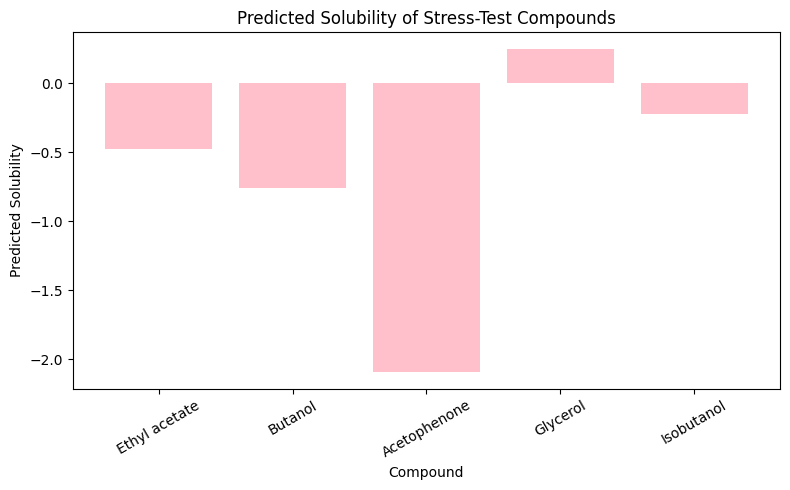

In [13]:

stress_compounds = [
    ("Ethyl acetate", "CCOC(=O)C"),
    ("Butanol", "CCCCO"),
    ("Acetophenone", "CC(=O)c1ccccc1"),
    ("Glycerol", "C(C(CO)O)O"),
    ("Isobutanol", "CC(C)CO")
]

names, test_smiles = zip(*stress_compounds)
X_test_smiles = preprocess_smiles(test_smiles, stoi, MAX_LEN).to(device)

model.eval()
with torch.no_grad():
    preds_norm = model(X_test_smiles)
    preds = preds_norm * y_std + y_mean

df_results = pd.DataFrame({
    "Compound": names,
    "SMILES": test_smiles,
    "Predicted Solubility": preds.cpu().numpy()
})
print("Predicted solubilities (stress-test compounds):")
display(df_results)

plt.figure(figsize=(8, 5))
plt.bar(df_results['Compound'], df_results['Predicted Solubility'], color='pink')
plt.xlabel("Compound")
plt.ylabel("Predicted Solubility")
plt.title("Predicted Solubility of Stress-Test Compounds")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## Aromatic group predictions


Predicted solubilities (aromatic test compounds, grouped):


,Compound,SMILES,Predicted Solubility
0,Phenol,c1ccccc1O,-0.954797
1,Hydroquinone,c1cc(ccc1O)O,-0.768174
2,Aniline,c1ccccc1N,-1.166811
3,Nitrobenzene,c1ccccc1[N+](=O)[O-],-1.916114
4,Benzaldehyde,O=CC1=CC=CC=C1,-1.791580
5,Benzene,c1ccccc1,-2.226143
6,Toluene,Cc1ccccc1,-2.420617
7,Chlorobenzene,c1ccccc1Cl,-2.884544
8,Bromobenzene,c1ccccc1Br,-2.803269
9,Acetophenone,CC(=O)c1ccccc1,-2.096653


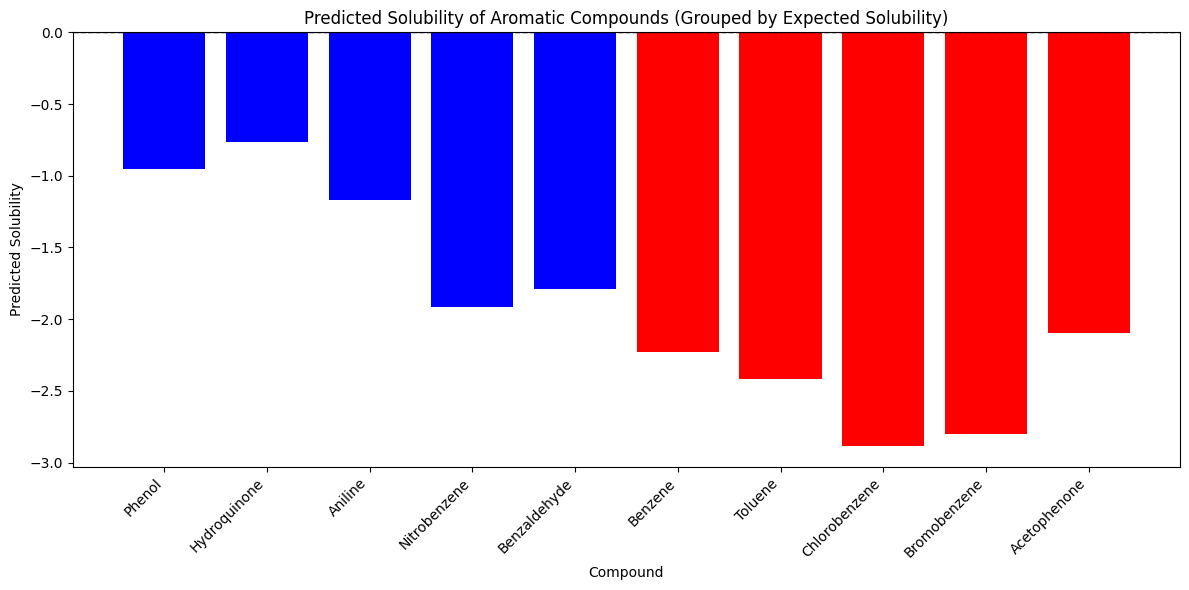

In [14]:

soluble_compounds = [
    ("Phenol", "c1ccccc1O"),
    ("Hydroquinone", "c1cc(ccc1O)O"),
    ("Aniline", "c1ccccc1N"),
    ("Nitrobenzene", "c1ccccc1[N+](=O)[O-]"),
    ("Benzaldehyde", "O=CC1=CC=CC=C1")
]

insoluble_compounds = [
    ("Benzene", "c1ccccc1"),
    ("Toluene", "Cc1ccccc1"),
    ("Chlorobenzene", "c1ccccc1Cl"),
    ("Bromobenzene", "c1ccccc1Br"),
    ("Acetophenone", "CC(=O)c1ccccc1")
]

all_compounds = soluble_compounds + insoluble_compounds
names, test_smiles = zip(*all_compounds)

X_test_smiles = preprocess_smiles(test_smiles, stoi, MAX_LEN).to(device)
model.eval()
with torch.no_grad():
    preds_norm = model(X_test_smiles)
    preds = preds_norm * y_std + y_mean

df_results = pd.DataFrame({
    "Compound": names,
    "SMILES": test_smiles,
    "Predicted Solubility": preds.cpu().numpy()
})
print("Predicted solubilities (aromatic test compounds, grouped):")
display(df_results)

plt.figure(figsize=(12, 6))
colors = ['blue'] * len(soluble_compounds) + ['red'] * len(insoluble_compounds)
plt.bar(names, df_results['Predicted Solubility'], color=colors)
plt.xlabel("Compound")
plt.ylabel("Predicted Solubility")
plt.title("Predicted Solubility of Aromatic Compounds (Grouped by Expected Solubility)")
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()
